In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.ops import nms

from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [2]:
class DETRmodel(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [5]:
def load_detr(weights_url,num_classes=91,try_gpu=True,gpu_id="cuda:0"):
    #"file:/opt/quantum/detr-1/weights/detr.pth"
    ##'https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth'
    DEVICE=torch.device("cpu")
    if try_gpu:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = DETRmodel(num_classes=num_classes)
    state_dict=torch.hub.load_state_dict_from_url(
        url=weights_url,
        map_location='cpu', 
        check_hash=True
    )
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    return model

In [9]:
#detr = DETRdemo(num_classes=91)
##"file:/opt/quantum/detr-1/weights/detr-r50-e632da11.pth"
#state_dict = torch.hub.load_state_dict_from_url(
#    url="file:/opt/quantum/detr-1/weights/detr.pth", #'https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
#    map_location='cpu', check_hash=True)
#torch.save(state_dict,"../../detr.pth")
#print(state_dict.keys())
#detr.load_state_dict(state_dict)
##detr.to(DEVICE)
#detr.eval();

detr=load_detr('file:/opt/quantum/detr-1/weights/detr.pth',try_gpu=True)

#detr=load_detr('file:/opt/quantum/vision_transformers/runs/training/detr_resnet50/best_model.pth',num_classes=6,try_gpu=True)


Downloading: "file:/opt/quantum/detr-1/weights/detr.pth" to /home/fgerard/.cache/torch/hub/checkpoints/detr.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79.3M/79.3M [00:00<00:00, 530MB/s]


In [10]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [11]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox_xyxy, size):
    img_w, img_h = size
    b = out_bbox_xyxy * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(DEVICE)
    return b

def create_objects(prob,boxes):
    result=[]
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        prob = p[cl].item()*100
        result.append([int(cl),int(prob),int(xmin),int(ymin),int(xmax),int(ymax)])
    return result


In [12]:
def detect(im, model, transform, min_score=0.7, iou_threshold=0.5):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0).to(DEVICE)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > min_score

    ## hacer NMS
    max_score_values=probas.max(-1).values
    boxes_xyxy=box_cxcywh_to_xyxy(outputs['pred_boxes'][0])
    
    #print("probas: {} {}".format(max_score_values.shape,max_score_values))
    #print("boxes_xyxy: {} {}".format(boxes_xyxy.shape,boxes_xyxy))
    
    good_index=nms(boxes=boxes_xyxy,scores=max_score_values, iou_threshold=iou_threshold)
    
    #print("good_index: {} {}".format(good_index.shape,good_index))

    d_keep=torch.zeros(100, dtype=torch.bool).to(DEVICE)
    d_keep[good_index]=True
    #print("keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))
    #print("d_keep: {} {} {}".format(d_keep.shape,d_keep,torch.sum(d_keep).item()))
    keep = torch.logical_and(keep, d_keep)
    #print("2keep: {} {} {}".format(keep.shape,keep,torch.sum(keep).item()))

    bboxes_scaled = rescale_bboxes(boxes_xyxy[keep], im.size)
    return probas[keep], bboxes_scaled

In [13]:
ims = [
    Image.open("/mnt/disco2T/opt/develop/DATASETS/aduana/dataset-git/output/ADU-crit01.5-2023-04-12-11-b9020609/val.002827.jpg")
]
idx=0
im = ims[idx]
scores, boxes = detect(im, detr, transform,min_score=0.85)
result=create_objects(scores,boxes)
print(torch.tensor(result).shape)
result

torch.Size([1, 6])


[[8, 99, 0, 58, 479, 252]]

In [14]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=6,bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

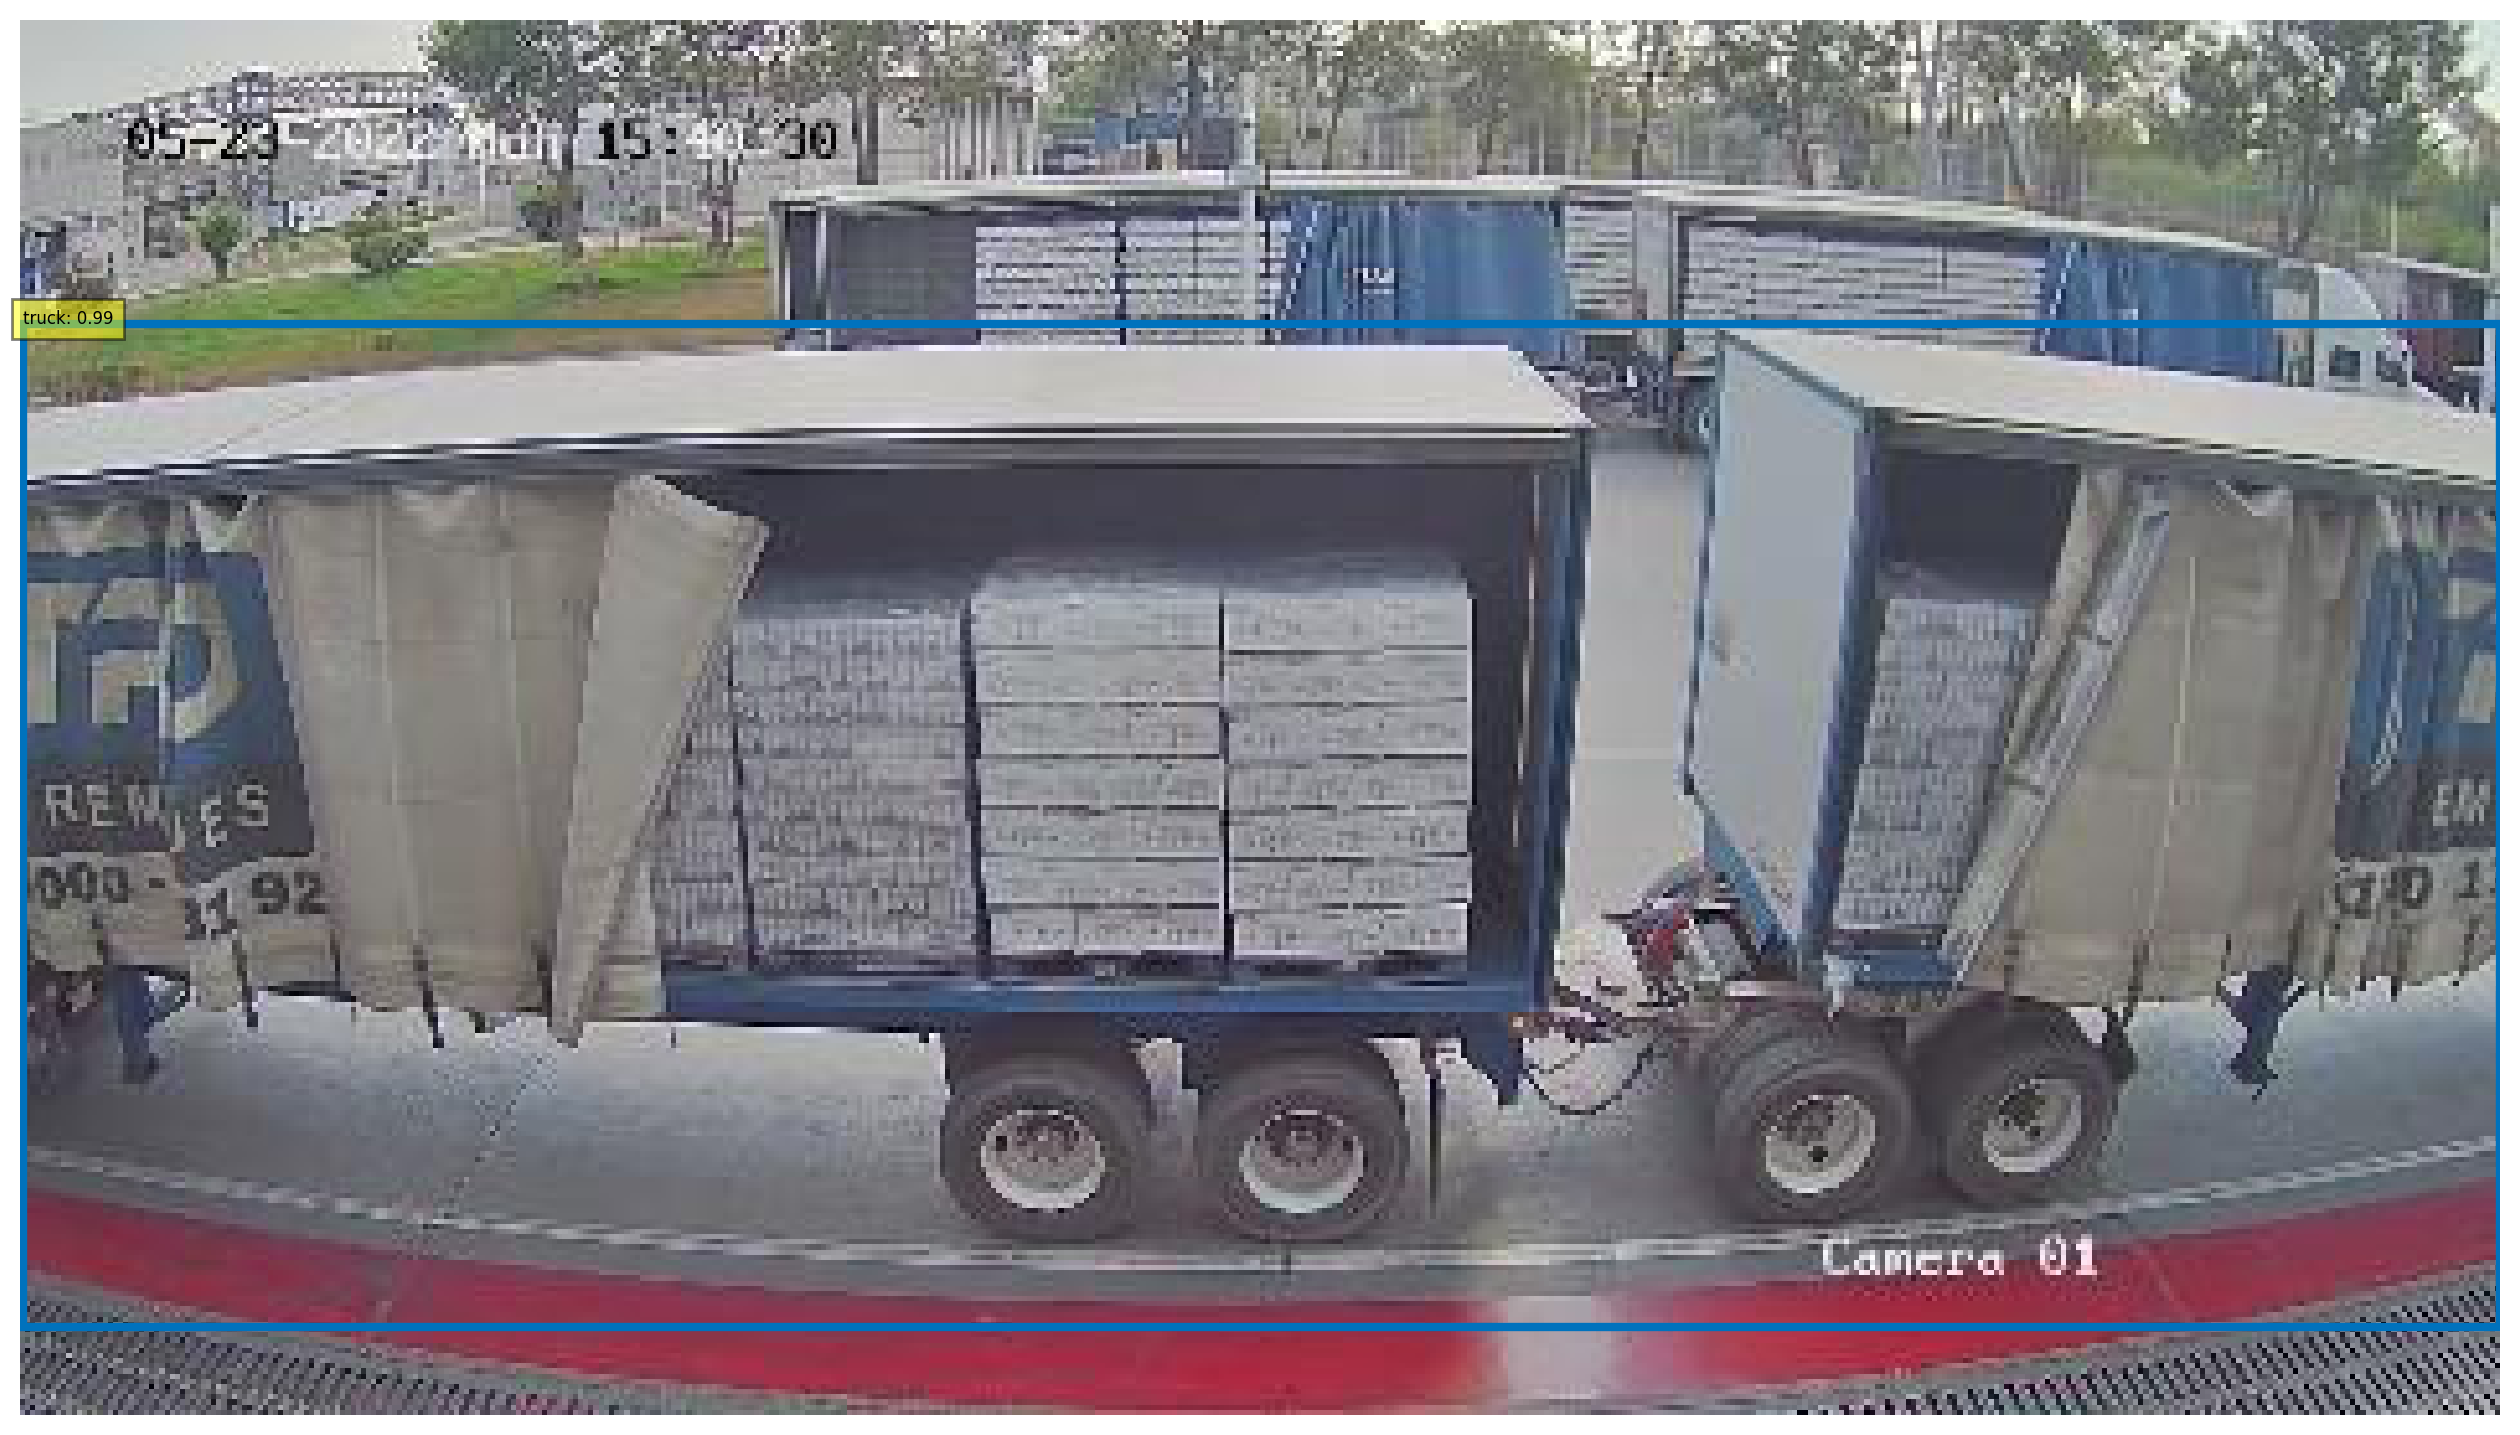

In [15]:
plot_results(im, scores, boxes)

In [16]:
t=torch.tensor([
    [1, 98, 120, 168, 261, 339],
    [1, 97, 523, 334, 666, 499],
    [1, 94, 0, 0, 160, 169],
    [1, 96, 0, 338, 122, 499],
    [1, 97, 252, 337, 380, 499],
    [1, 98, 402, 1, 548, 174],
    [1, 83, 541, 1, 778, 175],
    [1, 98, 387, 335, 522, 499],
    [1, 97, 127, 338, 285, 499],
    [1, 98, 663, 334, 794, 498],
    [1, 95, 665, 0, 794, 170],
    [1, 96, 118, 1, 277, 170],
    [1, 98, 255, 169, 394, 340],
    [1, 73, 539, 1, 683, 173],
    [1, 97, 265, 1, 415, 174],
    [1, 96, 525, 165, 673, 361],
    [1, 98, 664, 169, 794, 340],
    [1, 97, 398, 170, 526, 340],
    [1, 94, 399, 171, 525, 340],
    [1, 98, 0, 171, 123, 336]
])
print(t.shape)
t

torch.Size([20, 6])


tensor([[  1,  98, 120, 168, 261, 339],
        [  1,  97, 523, 334, 666, 499],
        [  1,  94,   0,   0, 160, 169],
        [  1,  96,   0, 338, 122, 499],
        [  1,  97, 252, 337, 380, 499],
        [  1,  98, 402,   1, 548, 174],
        [  1,  83, 541,   1, 778, 175],
        [  1,  98, 387, 335, 522, 499],
        [  1,  97, 127, 338, 285, 499],
        [  1,  98, 663, 334, 794, 498],
        [  1,  95, 665,   0, 794, 170],
        [  1,  96, 118,   1, 277, 170],
        [  1,  98, 255, 169, 394, 340],
        [  1,  73, 539,   1, 683, 173],
        [  1,  97, 265,   1, 415, 174],
        [  1,  96, 525, 165, 673, 361],
        [  1,  98, 664, 169, 794, 340],
        [  1,  97, 398, 170, 526, 340],
        [  1,  94, 399, 171, 525, 340],
        [  1,  98,   0, 171, 123, 336]])

In [17]:
b=t[:,2:]*1.0
print(b.shape)
b

torch.Size([20, 4])


tensor([[120., 168., 261., 339.],
        [523., 334., 666., 499.],
        [  0.,   0., 160., 169.],
        [  0., 338., 122., 499.],
        [252., 337., 380., 499.],
        [402.,   1., 548., 174.],
        [541.,   1., 778., 175.],
        [387., 335., 522., 499.],
        [127., 338., 285., 499.],
        [663., 334., 794., 498.],
        [665.,   0., 794., 170.],
        [118.,   1., 277., 170.],
        [255., 169., 394., 340.],
        [539.,   1., 683., 173.],
        [265.,   1., 415., 174.],
        [525., 165., 673., 361.],
        [664., 169., 794., 340.],
        [398., 170., 526., 340.],
        [399., 171., 525., 340.],
        [  0., 171., 123., 336.]])

In [18]:
p=t[:,1]/100.0
print(p.shape)
p

torch.Size([20])


tensor([0.9800, 0.9700, 0.9400, 0.9600, 0.9700, 0.9800, 0.8300, 0.9800, 0.9700,
        0.9800, 0.9500, 0.9600, 0.9800, 0.7300, 0.9700, 0.9600, 0.9800, 0.9700,
        0.9400, 0.9800])

In [19]:
keep_indices=nms(boxes=b,scores=p, iou_threshold=0.5)
print(keep_indices.shape)
indices=sorted(keep_indices.tolist())
indices

torch.Size([18])


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19]